In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
# Load the data
df = pd.read_excel("../data/raw/premiums.xlsx")

print("Data rows and columns: ", df.shape)

df.head()

Data rows and columns:  (50000, 13)


,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


In [49]:
# make all column names in python convention
df.columns = df.columns.str.lower().str.replace(" ", "_")
df.columns

Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount'],
      dtype='object')

In [50]:
# Check for missing values
df.isnull().sum()

age                       0
gender                    0
region                    0
marital_status            0
number_of_dependants      0
bmi_category              0
smoking_status           11
employment_status         2
income_level             13
income_lakhs              0
medical_history           0
insurance_plan            0
annual_premium_amount     0
dtype: int64

In [51]:
# Since the missing values are few and we have a large dataset, we can drop them
df.dropna(inplace=True)
df.isnull().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [52]:
# Check for duplicates
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [53]:
# Check for summary of the numerical columns
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49976.000000,49976.000000,49976.000000,49976.000000
mean,34.591764,1.711842,23.021150,15766.810189
std,15.000378,1.498195,24.221794,8419.995271
min,18.000000,-3.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8607.750000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22273.500000
max,356.000000,5.000000,930.000000,43471.000000


### Handle Outliers and Anomalies In The Numerical Columns

In [54]:
df[df["number_of_dependants"] < 0]["number_of_dependants"].unique()

array([-3, -1])

In [55]:
df["number_of_dependants"] = abs(df["number_of_dependants"])
print("Number of Records with Negative Number of Dependents", df[df["number_of_dependants"] < 0].shape[0])

Number of Records with Negative Number of Dependents 0


In [56]:
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
numeric_cols

['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount']

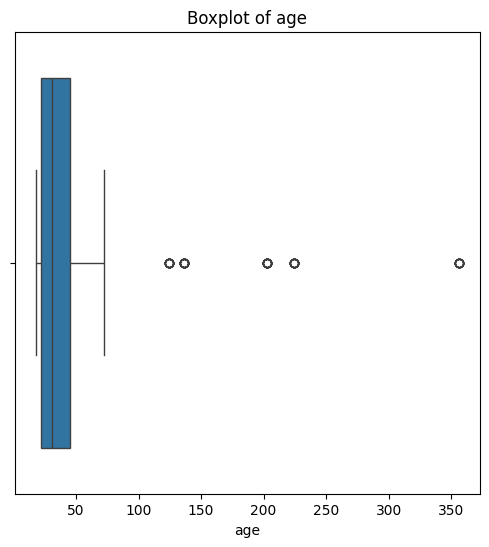

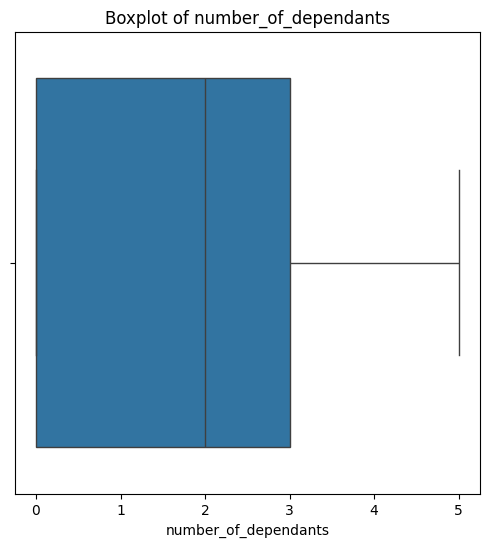

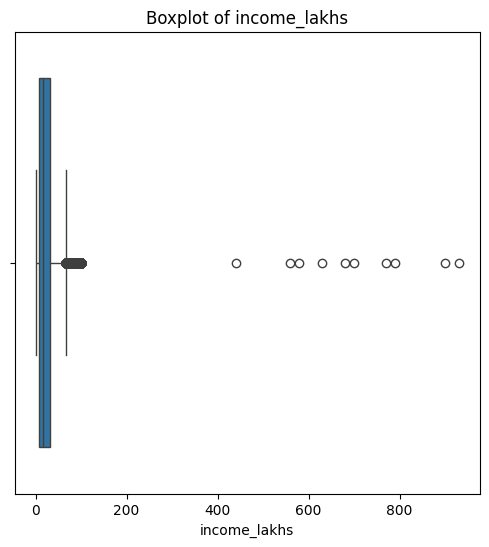

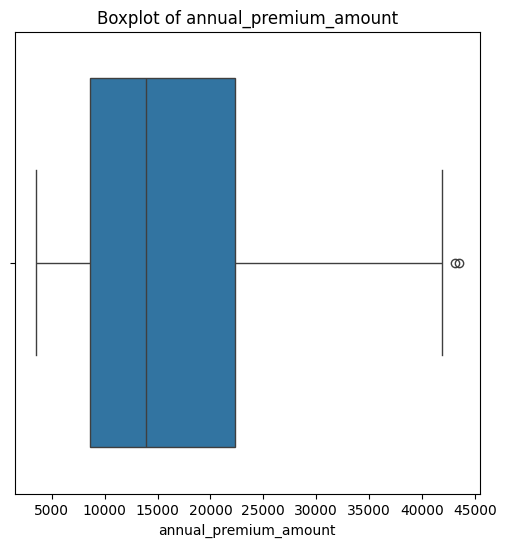

In [57]:
for col in numeric_cols:
    plt.figure(figsize=(6, 6))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

### Outliers and Anomalies Insights

- The `number_of_dependants` is free of outliers as all points are within the whiskers of the boxplot and we removed negative values.
- The `age` column has a few outliers above the upper whisker which by common sense would not be possible.
- The `annual_premium_amount` column can remain because in reality some amounts are rather high, the outliers are not too far from the whiskers, and they are very few in number.
- Overall, the outliers can even be dropped since they are few and we have a large dataset.

In [61]:
# Handle Outliers in the age column
print("Unique outlier age values: ", df[df["age"] > 100]["age"].unique())
print("Number of Records with age Greater Than 100:", df[df["age"] > 100].shape[0])

# From business understanding, we can assume that the age of a person cannot be greater than 100
# So far we have dropped very few records so we drop this small number of records
df1 = df[df["age"] <= 100]

Unique outlier age values:  [224 124 136 203 356]
Number of Records with age Greater Than 100: 58


In [64]:
# Handle outliers in the income column

def get_iqr_bounds(data, col):
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    return lower_bound, upper_bound

lower_bound, upper_bound = get_iqr_bounds(df1, "income_lakhs")
print("Income Lower Bound: ", lower_bound)
print("Income Upper Bound: ", upper_bound)
print("99.9th percentile of income: ", df1["income_lakhs"].quantile(0.999))

Income Lower Bound:  -29.0
Income Upper Bound:  67.0
99.9th percentile of income:  100.0


In [67]:
# Even though the 99.9th percentile is greater than IQR upper bound, 100 lakhs = 1 crore is a reasonable income
# So our upper bound will be the 99.9th percentile
upper_income_limit = df1["income_lakhs"].quantile(0.999)
print(df[df["income_lakhs"] > upper_income_limit].shape[0])

# Since the number of records above the limit is very small, we can drop them
df2 = df1[df1["income_lakhs"] <= upper_income_limit]
df2["income_lakhs"].describe()

10


count    49908.000000
mean        22.889897
std         22.170699
min          1.000000
25%          7.000000
50%         17.000000
75%         31.000000
max        100.000000
Name: income_lakhs, dtype: float64